# **CvDl2024_G Final Project MIGC Demo**

# **Install dependencies**

In [1]:
!pip install --upgrade --no-cache-dir gdown
!pip install transformers
!pip install torch
!pip install accelerate
!pip install flask
!pip install pyngrok
!pip install opencv-python
!pip install einops
!pip install diffusers==0.25.0
!pip install omegaconf

In [4]:
!git clone https://github.com/limuloo/MIGC.git
%cd MIGC
!pip install -r requirement.txt

Cloning into 'MIGC'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 301 (delta 24), reused 30 (delta 14), pack-reused 258 (from 1)
Receiving objects: 100% (301/301), 34.19 MiB | 24.20 MiB/s, done.
Resolving deltas: 100% (136/136), done.
/content/MIGC/MIGC/MIGC
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.21.1-py3-none-any.whl size=1486541 sha256=6f5c2c739517b6feefb861914cfafcc27ae6563efee8b69cc52fdb55c11b9dbc
  Stored in directory: /root/.cache/pip/wheels/a8/52/ec/901d7f3e1128bc56ea4365e9d3a157c1088e5450f4e8f7b202
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.25.0
    Uninstalling diffusers-0.25.0:
      Su

In [5]:
!pwd

/content/MIGC/MIGC/MIGC


In [6]:
!pip install -e .

Obtaining file:///content/MIGC/MIGC/MIGC
  Preparing metadata (setup.py) ... done
  Attempting uninstall: MIGC
    Found existing installation: MIGC 0.1
    Uninstalling MIGC-0.1:
      Successfully uninstalled MIGC-0.1
  Running setup.py develop for MIGC


In [7]:
!gdown --id 1v5ik-94qlfKuCx-Cv1EfEkxNBygtsz0T -O ./pretrained_weights/MIGC_SD14.ckpt
!gdown --id 1cmdif24erg3Pph3zIZaUoaSzqVEuEfYM -O ./migc_gui_weights/sd/cetusMix_Whalefall2.safetensors
!gdown --id 1Z_BFepTXMbe-cib7Lla5A224XXE1mBcS -O ./migc_gui_weights/clip/text_encoder/pytorch_model.bin

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1v5ik-94qlfKuCx-Cv1EfEkxNBygtsz0T
From (redirected): https://drive.google.com/uc?id=1v5ik-94qlfKuCx-Cv1EfEkxNBygtsz0T&confirm=t&uuid=af0d8a61-3789-4998-86fa-f7e509ea5eea
To: /content/MIGC/MIGC/MIGC/pretrained_weights/MIGC_SD14.ckpt
100% 230M/230M [00:02<00:00, 90.1MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many peopl

# **Construct StableDiffusionMIGCPipeline**

In [8]:
import argparse
import numpy as np
import torch
import os
import yaml
import random
from diffusers.utils.import_utils import is_accelerate_available
from transformers import CLIPTextModel, CLIPTokenizer
from migc.migc_pipeline import StableDiffusionMIGCPipeline, MIGCProcessor, AttentionStore
from diffusers import EulerDiscreteScheduler
if is_accelerate_available():
    from accelerate import init_empty_weights
from contextlib import nullcontext

def offlinePipelineSetupWithSafeTensor(sd_safetensors_path):
    migc_ckpt_path = '/content/MIGC/pretrained_weights/MIGC_SD14.ckpt'
    clip_model_path = '/content/MIGC/migc_gui_weights/clip/text_encoder'
    clip_tokenizer_path = '/content/MIGC/migc_gui_weights/clip/tokenizer'
    original_config_file='/content/MIGC/migc_gui_weights/v1-inference.yaml'
    ctx = init_empty_weights if is_accelerate_available() else nullcontext
    with ctx():
        # text_encoder = CLIPTextModel(config)
        text_encoder = CLIPTextModel.from_pretrained(clip_model_path)
        tokenizer = CLIPTokenizer.from_pretrained(clip_tokenizer_path)
    pipe = StableDiffusionMIGCPipeline.from_single_file(sd_safetensors_path,
                                                    original_config_file=original_config_file,
                                                    text_encoder=text_encoder,
                                                    tokenizer=tokenizer,
                                                    load_safety_checker=False)
    print('Initializing pipeline')
    pipe.attention_store = AttentionStore()
    from migc.migc_utils import load_migc
    load_migc(pipe.unet , pipe.attention_store,
            migc_ckpt_path, attn_processor=MIGCProcessor)

    pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
    return pipe

/content/MIGC/MIGC/MIGC/migc/migc_pipeline.py:117: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(batch_size == 2, "We currently only implement sampling with batch_size=1, \


In [18]:
import os
# $cd ..
print(os.getcwd())
print(os.path.exists('MIGC/migc_gui_weights/sd/cetusMix_Whalefall2.safetensors'))
print(os.listdir('MIGC/migc_gui_weights/sd/'))

/content/MIGC/MIGC
/content/MIGC
/content/MIGC
False
['PUT_SD_SAFETENSORS_HERE']


In [19]:
import yaml
from diffusers import EulerDiscreteScheduler
from migc.migc_utils import seed_everything
from migc.migc_pipeline import StableDiffusionMIGCPipeline, MIGCProcessor, AttentionStore
import os
from google.colab.patches import cv2_imshow, cv2

# migc_ckpt_path = 'pretrained_weights/MIGC_SD14.ckpt'
# assert os.path.isfile(migc_ckpt_path), "Please download the ckpt of migc and put it in the pretrained_weighrs/ folder!"


pipe = offlinePipelineSetupWithSafeTensor('./migc_gui_weights/sd/cetusMix_Whalefall2.safetensors')
pipe = pipe.to("cuda")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for text_model.embeddings.token_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for text_model.embeddings.position_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for text_model.encoder.layers.0.self_attn.k_proj.weight: copying from a non-m

Initializing pipeline


# **Generate Image**

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:430: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


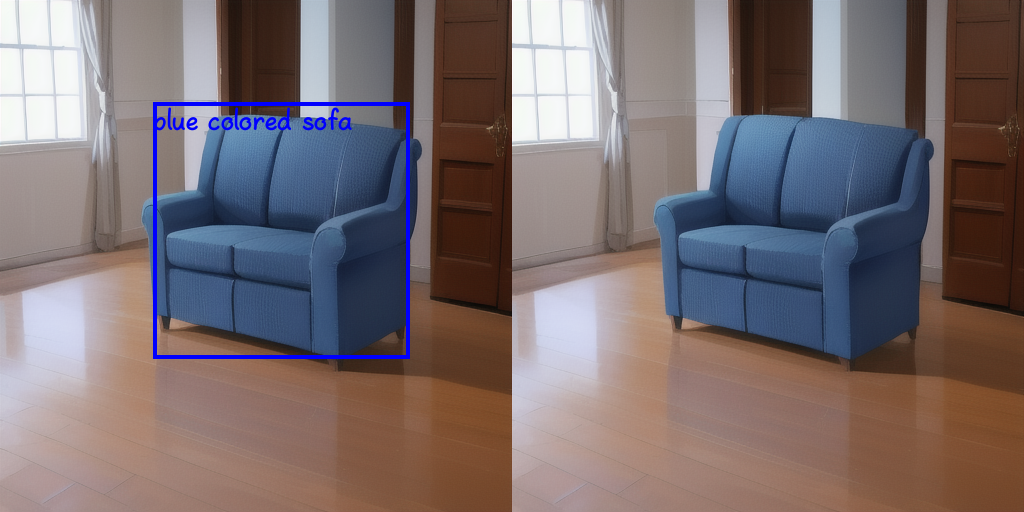

In [21]:
prompt_final = [['masterpiece, best quality, blue colored sofa', 'blue colored sofa']]

bboxes = [[[0.3, 0.2, 0.8, 0.7]]]

negative_prompt = 'worst quality, low quality, bad anatomy, watermark, text, blurry'
seed = 42
seed_everything(seed)

image = pipe(
    prompt_final,
    bboxes,
    num_inference_steps=30,
    guidance_scale=7.5,
    MIGCsteps=15,
    aug_phase_with_and=False,
    negative_prompt=negative_prompt,
    NaiveFuserSteps=30
).images[0]

image.save('output.png')
image.show()

image = pipe.draw_box_desc(image, bboxes[0], prompt_final[0][1:])
image.save('anno_output.png')
image.show()

img_anno = cv2.imread('./anno_output.png')
img = cv2.imread('./output.png')
cv2_imshow(np.concatenate([img_anno, img], axis=1))

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:430: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


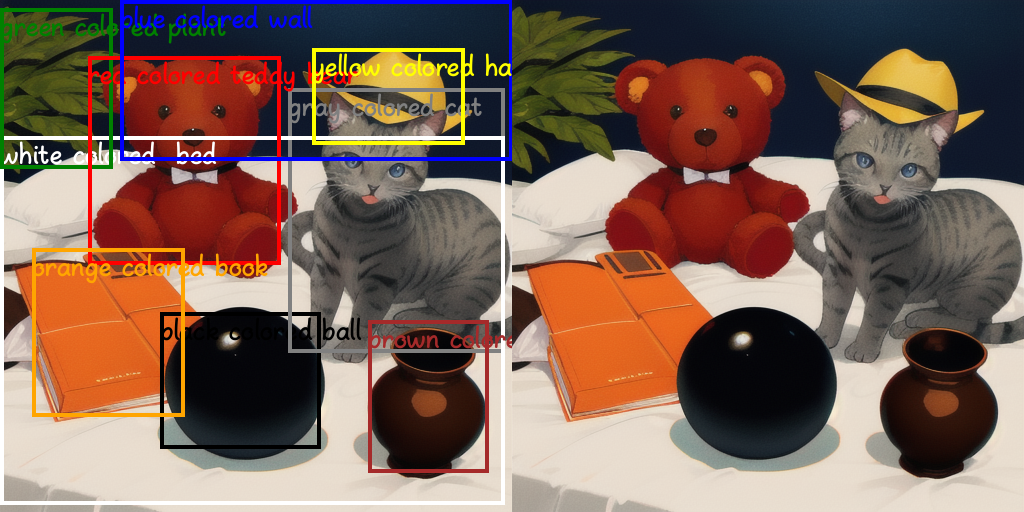

In [20]:
prompt_final = [['masterpiece, best quality,black colored ball,gray colored cat,white colored  bed,\
                  green colored plant,red colored teddy bear,blue colored wall,brown colored vase,orange colored book,\
                  yellow colored hat', 'black colored ball', 'gray colored cat', 'white colored  bed', 'green colored plant', \
                    'red colored teddy bear', 'blue colored wall', 'brown colored vase', 'orange colored book', 'yellow colored hat']]
bboxes = [[[0.3125, 0.609375, 0.625, 0.875], [0.5625, 0.171875, 0.984375, 0.6875], \
            [0.0, 0.265625, 0.984375, 0.984375], [0.0, 0.015625, 0.21875, 0.328125], \
            [0.171875, 0.109375, 0.546875, 0.515625], [0.234375, 0.0, 1.0, 0.3125], \
                [0.71875, 0.625, 0.953125, 0.921875], [0.0625, 0.484375, 0.359375, 0.8125], \
                    [0.609375, 0.09375, 0.90625, 0.28125]]]
negative_prompt = 'worst quality, low quality, bad anatomy, watermark, text, blurry'
seed = 7351007268695528845
seed_everything(seed)
image = pipe(prompt_final, bboxes, num_inference_steps=30, guidance_scale=7.5,
                MIGCsteps=15, aug_phase_with_and=False, negative_prompt=negative_prompt, NaiveFuserSteps=30).images[0]
image.save('output1.png')
image.show()
image = pipe.draw_box_desc(image, bboxes[0], prompt_final[0][1:])
image.save('anno_output1.png')
image.show()


img_anno = cv2.imread('./anno_output1.png')
img = cv2.imread('./output1.png')
cv2_imshow(np.concatenate([img_anno, img], axis=1))


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:430: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


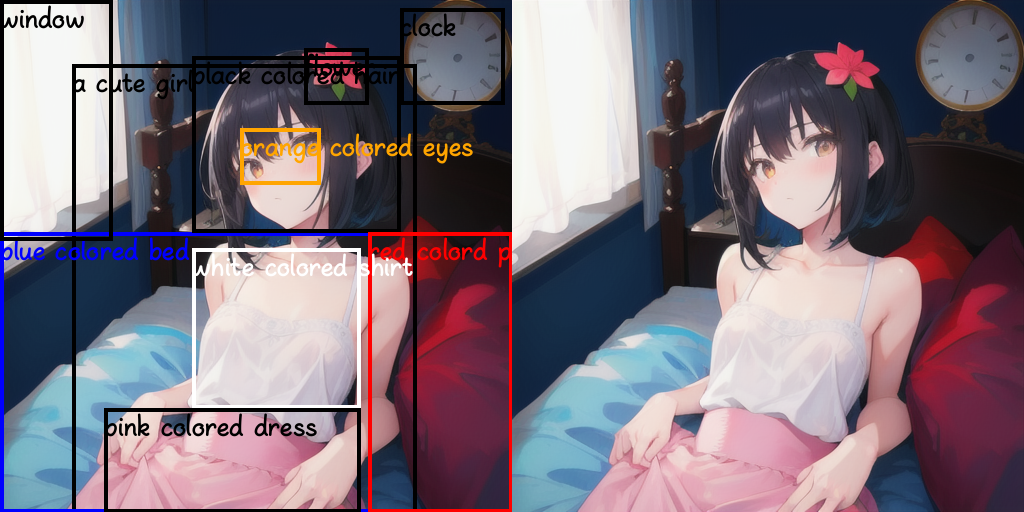

In [22]:
prompt_final = [['4k, best quality, masterpiece, ultra high res, ultra detailed,a cute girl,blue colored bed,window,\
                clock,black colored hair,orange colored eyes,red colord pillow,white colored shirt,pink colored dress,flower', \
                 'a cute girl', 'blue colored bed', 'window', 'clock', 'black colored hair', 'orange colored eyes', 'red colord pillow', \
                 'white colored shirt', 'pink colored dress', 'flower']]
bboxes = [[[0.140625, 0.125, 0.8125, 1.0], [0.0, 0.453125, 1.0, 1.0], [0.0, 0.0, 0.21875, 0.46875],
 [0.78125, 0.015625, 0.984375, 0.203125], [0.375, 0.109375, 0.78125, 0.453125], [0.46875, 0.25, 0.625, 0.359375],
  [0.71875, 0.453125, 1.0, 1.0], [0.375, 0.484375, 0.703125, 0.796875], [0.203125, 0.796875, 0.703125, 1.0], [0.59375, 0.09375, 0.71875, 0.203125]]]
negative_prompt = 'worst quality, low quality, bad anatomy, watermark, text, blurry'
seed = 4988741440008356583
seed_everything(seed)
image = pipe(prompt_final, bboxes, num_inference_steps=30, guidance_scale=8.0,
                MIGCsteps=15, aug_phase_with_and=False, negative_prompt=negative_prompt, NaiveFuserSteps=30).images[0]
image.save('output2.png')
image.show()
image = pipe.draw_box_desc(image, bboxes[0], prompt_final[0][1:])
image.save('anno_output2.png')
image.show()


img_anno = cv2.imread('./anno_output2.png')
img = cv2.imread('./output2.png')
cv2_imshow(np.concatenate([img_anno, img], axis=1))


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:430: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


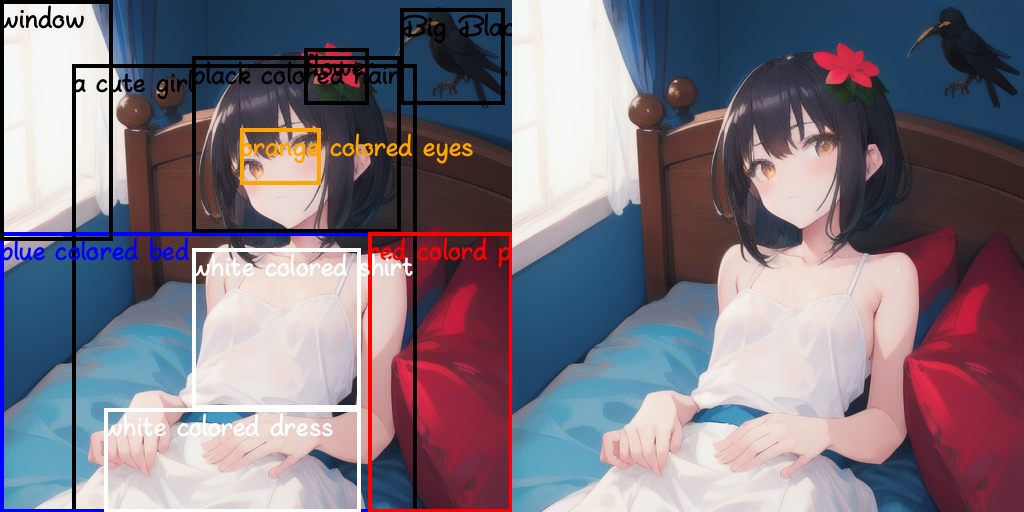

In [24]:
prompt_final = [['4k, best quality, masterpiece, ultra high res, ultra detailed,a cute girl,blue colored bed,window,\
                clock,black colored hair,orange colored eyes,red colord pillow,white colored shirt,white colored dress,flower', \
                 'a cute girl', 'blue colored bed', 'window', 'big black bird', 'black colored hair', 'orange colored eyes', 'red colord pillow', \
                 'white colored shirt', 'white colored dress', 'flower']] # `Clock` change to `big black bird`
bboxes = [[[0.140625, 0.125, 0.8125, 1.0], [0.0, 0.453125, 1.0, 1.0], [0.0, 0.0, 0.21875, 0.46875],
 [0.78125, 0.015625, 0.984375, 0.203125], [0.375, 0.109375, 0.78125, 0.453125], [0.46875, 0.25, 0.625, 0.359375],
  [0.71875, 0.453125, 1.0, 1.0], [0.375, 0.484375, 0.703125, 0.796875], [0.203125, 0.796875, 0.703125, 1.0], [0.59375, 0.09375, 0.71875, 0.203125]]]
negative_prompt = 'worst quality, low quality, bad anatomy, watermark, text, blurry'
seed = 4988741440008356583
seed_everything(seed)
image = pipe(prompt_final, bboxes, num_inference_steps=30, guidance_scale=8.0,
                MIGCsteps=15, aug_phase_with_and=False, negative_prompt=negative_prompt, NaiveFuserSteps=30).images[0]
image.save('output2.png')
image.show()
image = pipe.draw_box_desc(image, bboxes[0], prompt_final[0][1:])
image.save('anno_output2.png')
image.show()


img_anno = cv2.imread('./anno_output2.png')
img = cv2.imread('./output2.png')
cv2_imshow(np.concatenate([img_anno, img], axis=1))
